In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [56]:
# TODO Add room map
rooms = []

room_df = pd.read_csv(
    '../data/Trends Smart City/0EG/EG-R0-09-1 Lufttemp.CSV',
    sep=';',
    parse_dates=True,
    header=0,
    index_col=0,
    names=['EG R0-09', '_1', '_2', '_3'],
    )
rooms.append(room_df.iloc[:,0].dropna())
rooms = pd.concat(rooms, axis=1)
rooms.index.name = 'Time'
rooms.head()

,EG R0-09
Time,
2021-11-17 17:13:24,24.340000
2021-11-17 17:28:24,19.490000
2021-11-18 00:28:24,24.110001
2021-11-18 08:28:24,24.250000
2021-11-18 17:13:36,24.590000


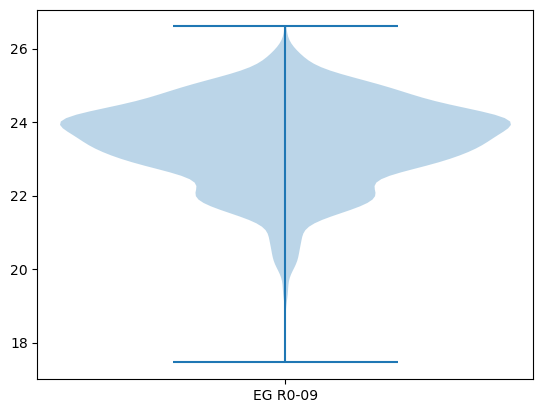

In [57]:
fig, ax = plt.subplots()

ax.violinplot(rooms, widths=2)
ax.set_xticks(ticks=[1], labels=rooms.columns)
plt.show()